In [96]:
import pandas as pd
import glob
#import whois
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
json_files = glob.glob('*.json')

for json_file in json_files:
    variable_name = json_file.split('.')[0]
    df = pd.read_json(json_file)
    globals()[variable_name] = df

In [98]:
print(json_files)

['messages.json', 'priority.json', 'reputations.json', 'true_reputations.json']


# 1. Data cleaning

In [99]:
messages.isnull().sum()

id                       0
url                      0
date                     0
source                   0
protocol                 0
response_code         1005
load_time_seconds        0
domain_age_years     25095
page_size_kb             0
redirects                0
service                  0
dtype: int64

## 1.1. I see that there are missing values in response code and domain age columns.

In [100]:
messages['response_code'].value_counts()

response_code
200.0    80095
301.0    14935
404.0     3965
Name: count, dtype: int64

In [101]:
messages = messages.sort_values(['url', 'source', 'date'])

In [102]:
messages['response_code'] = messages.groupby(['url','source'])['response_code'].fillna(method = 'ffill')
messages['response_code'] = messages.groupby(['url','source'])['response_code'].fillna(method = 'bfill')

### We have successfully filled the missing response code values by following this logic:
### 1. We have grouped the data by url and source groups and filtered their entries by date
### 2. In these groups, we identify the blank response code values and apply the previous entries value
### 3. If the mentioned blank value is the very first one in this group, we fill it with the following date's response code value

## 1.2. Domain age

### Since there are a lot of missing domain age values and the one's that are available are obviously faulty (all of them fall into a range of 1-3 years), I will re-populate this column by scraping via the whois api

In [103]:
domains = messages['url'].unique().tolist()
domains_dict = {domain: '' for domain in domains}

In [104]:
len(domains)

2168

### There are a total of 2168 unique domain names - I will scrape the registration dates of all of them and store these values in a separate dictionary.

### The scraping code below is just an ilustration of how the date was extracted - in reality it was scraped in blocks of 100 with time intervals in between.

In [62]:
for domain in domains[100:200]:
        info = whois.whois(domain)
        registration_date = info.creation_date
        print(f"Domain: {domain}, Registration Date: {registration_date}")
        domains_dict[domain] = registration_date

Domain: 1xlite-377032.top, Registration Date: 2022-12-29 11:35:49
Domain: 20minutes.fr, Registration Date: 2001-07-11 22:00:00
Domain: 20minutos.es, Registration Date: None
Domain: 2345.com, Registration Date: 1998-01-19 05:00:00
Domain: 247sports.com, Registration Date: 2001-04-18 10:37:33
Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
Domain: 24h.com.vn, Registration Date: None
Domain: 2gis.ru, Registration Date: 2001-02-18 21:00:00
Domain: 2mdn.net, Registration Date: 2005-05-02 18:46:31
Domain: 33across.com, Registration Date: [datetime.datetime(2007, 9, 29, 20, 56, 11), datetime.datetime(2007, 9, 29, 15, 56, 11)]
Domain: 360yield.com, Registration Date: 2009-06-02 13:04:25
Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
Domain: 39flp.live, Registration Date: None
Domain: 3bmeteo.com, Registration Date: [datetime.datetime(1999, 4, 15, 4, 0), datetime.datetime(2017, 3, 1, 0, 0)]
Domain: 3dsplm.cn, Registratio

### Some dates have been populated as lists of tuples, we'll have to clean them up.

In [131]:
for domain, date in domains_dict.items():
    if type(date) == list:
        domains_dict[domain] = date[0]

In [132]:
df = pd.DataFrame(list(domains_dict.items()), columns=['Domain', 'Date'])

In [133]:
df.to_csv('domains.csv', index=False)

### The registration dates of these domains have been saved in a .csv file for later use to avoid repetitive scraping.

In [105]:
dates = pd.read_csv('domains.csv')

In [106]:
dates['Date'] = pd.to_datetime(dates['Date'], errors = 'coerce')

In [107]:
dates = dates.dropna(subset = ['Date'])

In [108]:
dates['age'] = ((datetime.now() - dates['Date']).dt.days / 365.25).round(1)

### Since there are some missing values, we'll fill them with the closest domain name's value

### Now that we have the accurate ages of most of the domains, let's put these values back into the messages dataframe

In [109]:
messages = messages.merge(dates[['Domain', 'age']], left_on = 'url', right_on = 'Domain', how = 'left')
messages = messages.drop(['domain_age_years', 'Domain'], axis = 1)

In [110]:
messages.isna().sum()

id                       0
url                      0
date                     0
source                   0
protocol                 0
response_code            0
load_time_seconds        0
page_size_kb             0
redirects                0
service                  0
age                  14835
dtype: int64

In [111]:
messages['domain'] = messages['url'].apply(lambda x: x.rsplit('.', 1)[0])
messages['TLD'] = messages['url'].apply(lambda x: x.split('.')[-1])

In [112]:
messages['age'] = messages.groupby('domain')['age'].fillna(method = 'ffill')
messages['age'] = messages.groupby('domain')['age'].fillna(method = 'bfill')

In [113]:
messages.isna().sum()

id                      0
url                     0
date                    0
source                  0
protocol                0
response_code           0
load_time_seconds       0
page_size_kb            0
redirects               0
service                 0
age                  7706
domain                  0
TLD                     0
dtype: int64

In [114]:
len(messages[messages['age'].isna()]['url'].unique())

170

### I have filled some of the missing domain ages by following a similar logic like I did with the response codes:
### 1. I've separated the url's to have sepaprate columns for domain names and TLD's.
### 2. I've grouped the data by domain name and filled all the blank age values with the previous non-blank value.
### 3. If the blank entry is the very first one in the group, I filled it with the very next one's values.
### 4. I am left with 170 unique domains that were unrecognized and I can't reliably fill in their registration ages.

## 1.3. I see that there are many faulty dates (e.g. dating back to 1938, etc. I have Identified that the logical starting point is 2020-01-01. I will categorize all the dates before that to be 2019-12-31, so that we know all the visual representations, dating back before 2020, are of an unclear date.

In [115]:
messages.loc[messages['date'] < '2020-01-01', 'date'] = '2019-12-31'

In [116]:
messages['date'].value_counts()

date
2019-12-31    1858
2024-02-17      93
2023-07-22      88
2023-03-18      87
2021-03-09      87
              ... 
2021-09-11      45
2022-01-20      45
2022-05-28      44
2021-09-02      43
2021-12-25      37
Name: count, Length: 1521, dtype: int64

# 2. Reputations

In [117]:
reps = reputations.merge(true_reputations, on = 'id', suffixes = ['_local', '_service'])

In [118]:
reps['reputation_category'].value_counts()

reputation_category
good       54233
neutral    26731
bad         9036
Name: count, dtype: int64

In [119]:
reps['true_reputation'].value_counts()

true_reputation
clean       53968
unknown      9089
phishing     9082
scam         8961
malware      8900
Name: count, dtype: int64

### The "good" reputations have almost identical amounts of entries, however the bad ones have to be categorized

In [120]:
def categorize(x):
    if x == 'clean': return 'good'
    elif x == 'unknown': return 'neutral'
    return 'bad'

reps['true_reputation_adjusted'] = reps['true_reputation'].apply(categorize)

In [121]:
reps['true_reputation_adjusted'].value_counts()

true_reputation_adjusted
good       53968
bad        26943
neutral     9089
Name: count, dtype: int64

In [122]:
reps['correct_reputation'] = reps['reputation_category'] == reps['true_reputation_adjusted']

In [123]:
reps.groupby('reputation_source_local')['correct_reputation'].value_counts(normalize=True).unstack() * 100

correct_reputation,False,True
reputation_source_local,,
source_1,57.909918,42.090082
source_2,57.552217,42.447783
source_3,57.753468,42.246532
source_4,57.880225,42.119775


### Local source reliability differences seem to be negligible, the difference between highest and lowest performers is just 0.45%

In [124]:
reps[reps['reputation_score']>=50].groupby('reputation_source_local')['correct_reputation'].value_counts(normalize=True).unstack() * 100

correct_reputation,False,True
reputation_source_local,,
source_1,58.607251,41.392749
source_2,57.525594,42.474406
source_3,58.353854,41.646146
source_4,56.780572,43.219428


### If we take into consideration the reputation score factor and filter out any instances where score is below 50, we get a slightly bigger distribution. Here, source 4 has the biggest score of 43.21%

In [125]:
bad_reps = reps[reps['reputation_category'] == 'bad']

In [126]:
bad_reps.groupby('reputation_source_local')['true_reputation_adjusted'].value_counts()

reputation_source_local  true_reputation_adjusted
source_1                 good                        1667
                         bad                          803
                         neutral                      287
source_2                 good                        1583
                         bad                          875
                         neutral                      277
source_3                 good                        1553
                         bad                          777
                         neutral                      259
source_4                 good                         564
                         bad                          290
                         neutral                      101
Name: count, dtype: int64

### Even when we filter out only the "Bad" reputation categories, we see a similar rate of category mismatches across all sources.

### Lets see if this tendency changes when we filter out only the most relevant messages of each URL:

# 3. URL info

In [127]:
urls = messages.merge(priority, on = 'id')

In [128]:
urls['url'].nunique()

2168

In [129]:
urls[urls['service'] == urls['priority']]['url'].nunique()

2168

### As we can see, there are no such cases where a url has no instances of priority service. Meaning that we don't have to adjust our logic for it.

In [130]:
urls = urls[urls['service'] == urls['priority']]

In [131]:
urls = urls.merge(reputations, on = 'id')

In [132]:
urls = urls.sort_values('reputation_date', ascending = False).drop_duplicates('url')

In [133]:
urls = urls.merge(true_reputations[['id', 'true_reputation']], on = 'id')

### We now have a list of unique URL's with their most relevant data. I'll save it into a separate .csv file for later use.

In [134]:
urls

,id,url,date,source,protocol,response_code,load_time_seconds,page_size_kb,redirects,service,age,domain,TLD,priority,timestamp,reputation_source,reputation_score,reputation_category,reputation_date,true_reputation
0,e825fa5e-5362-44d8-8b1f-ce88d8f763de,airbrake.io,2024-02-28,source_3,HTTPS,200.0,7.57,99,"[True, google.dm]",service_4,12.5,airbrake,io,service_4,2020-11-12,source_1,86,good,2024-02-28,scam
1,ce51c2c9-808c-4bac-b1a3-ce4f706973f3,thepennyhoarder.com,2024-02-28,source_4,HTTP,200.0,1.69,456,"[True, bluekai.com]",service_2,13.2,thepennyhoarder,com,service_2,2023-09-07,source_1,5,good,2024-02-28,clean
2,b181b1fb-48df-4a10-ab78-ef713e392990,arcpublishing.com,2024-02-28,source_1,HTTPS,301.0,8.08,167,False,service_1,14.6,arcpublishing,com,service_1,2023-01-18,source_1,48,bad,2024-02-28,clean
3,7126f73d-d342-4f32-9fec-cc3c9868db6b,thegioididong.com,2024-02-28,source_4,HTTP,200.0,0.60,297,False,service_3,20.4,thegioididong,com,service_3,2021-10-25,source_2,13,good,2024-02-28,clean
4,c06a9f56-0291-4916-843c-8c4da9d2fa6d,leboncoin.fr,2024-02-28,source_3,HTTP,301.0,9.15,377,False,service_3,17.1,leboncoin,fr,service_3,2023-11-22,source_1,31,neutral,2024-02-28,clean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,35e51da1-a2b3-4bb0-83a3-365b0f023f08,news.livedoor.com,2021-10-23,source_1,HTTPS,200.0,6.63,295,"[True, pinimg.com]",service_1,24.4,news.livedoor,com,service_1,2023-01-10,source_2,20,neutral,2021-10-23,clean
2164,b4743098-9987-4cee-9cd1-a35a0d6c6a9d,block.si,2021-10-09,source_4,HTTP,200.0,9.42,444,"[True, eesysoft.com, googlezip.net]",service_1,12.5,block,si,service_1,2022-09-11,source_1,45,bad,2021-10-09,clean
2165,738b7e9a-aedb-4edd-bf6a-6135ce7b21b0,blooket.com,2021-09-03,source_2,HTTPS,200.0,1.65,162,"[True, solvvy.com]",service_3,5.3,blooket,com,service_3,2022-06-28,source_3,19,good,2021-09-03,clean
2166,f851683f-7448-474d-878f-19f90a720e45,zoho.com,2021-06-22,source_2,HTTPS,200.0,7.82,166,False,service_1,20.1,zoho,com,service_1,2021-01-23,source_3,86,good,2021-06-22,clean


In [135]:
urls.to_csv('urls.csv', index=False)

# 3.1. Reputations of latest URL messages
### Lets check how our internal reputation services perform with this list

In [136]:
urls['true_reputation_adjusted'] = urls['true_reputation'].apply(categorize)

In [137]:
urls['correct_reputation'] = urls['reputation_category'] == urls['true_reputation_adjusted']

In [138]:
urls.groupby('reputation_source')['correct_reputation'].value_counts(normalize=True).unstack() * 100

correct_reputation,False,True
reputation_source,,
source_1,60.220126,39.779874
source_2,59.324523,40.675477
source_3,56.017831,43.982169
source_4,58.988764,41.011236


### The contrast between different local sources is more apparent now - with source_3 being the obvious leader with 43.83% success rate.

### Nevertheless, it is still a small success rate and it is apparent that internal reputation identifications sources aren't precise. True reputation categories should be used whenever possible.

In [139]:
urls['service'].value_counts(normalize=True) * 100

service
service_2    33.809963
service_3    31.549815
service_1    31.273063
service_4     3.367159
Name: proportion, dtype: float64

In [140]:
messages['service'].value_counts(normalize=True) * 100

service
service_2    30.118
service_3    29.938
service_1    29.753
service_4    10.191
Name: proportion, dtype: float64

### Service 4 has a massive drop in messages received when we consider only the priority sources

# 4. Exploratory Data Analysis

### 4.1. Now that I'm done with cleaning and modifying the dataset, I can begin exploring the dataset more. I'll begin with load time comparisons

In [141]:
pivot = messages.pivot_table(index = 'source', columns = 'service', values = 'load_time_seconds',
                             aggfunc = 'mean')

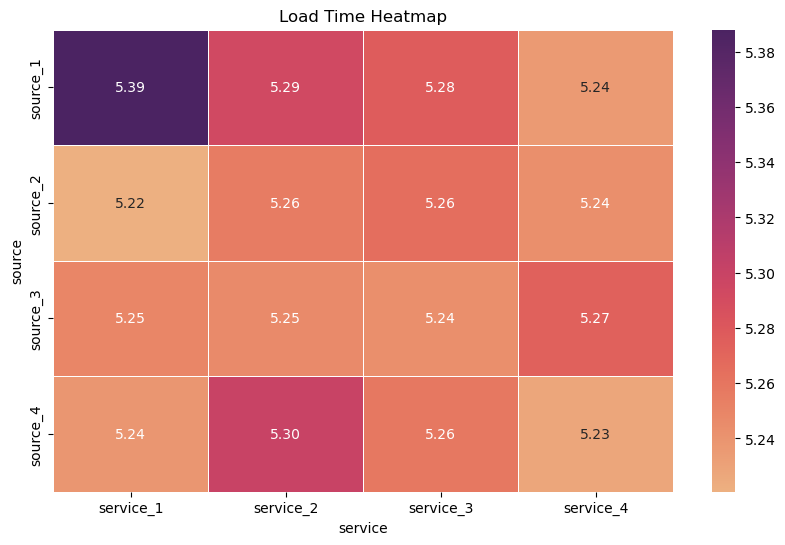

In [142]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="flare", fmt=".2f", linewidths=.5)
plt.title('Load Time Heatmap')
plt.show()

### The differences between loadtimes are negligible in both dimensions - when comparing services and sources.
### The biggest mean loadtime difference can be observed between service 1's source 1 and 2 performances (0.17 s difference)

In [143]:
messages['TLD'].value_counts()

TLD
com    56736
net     8520
io      2101
ru      1984
jp      1896
       ...  
mm        35
cm        34
jm        34
je        32
sk        31
Name: count, Length: 248, dtype: int64

### There are 248 different top-level domains. To gain some insight on how they compare, I'll ignore the one's that have fewer than 500 instances (at least 0.5% of all instances).

In [144]:
tlds = messages.groupby('TLD').filter(lambda x: len(x)>500)

In [145]:
tlds['TLD'].value_counts()

TLD
com    56736
net     8520
io      2101
ru      1984
jp      1896
org     1396
it       967
uk       940
de       851
fr       816
br       738
co       671
pl       644
cn       640
es       608
me       531
Name: count, dtype: int64

C:\Users\HP\AppData\Local\Temp\ipykernel_6628\2409416781.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(x='TLD', y='load_time_seconds', data=tlds, palette = 'flare', order=tld_occurrence,


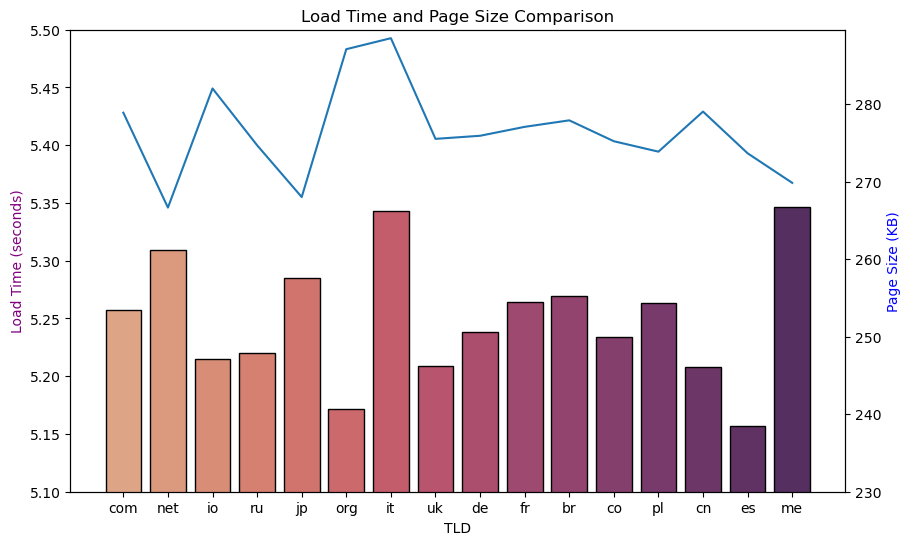

In [146]:
tld_occurrence = tlds['TLD'].value_counts().index

plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x='TLD', y='load_time_seconds', data=tlds, palette = 'flare', order=tld_occurrence,
                 ci=None, edgecolor = 'black')

plt.ylim(5.1, 5.5)

ax2 = ax1.twinx()
sns.lineplot(x='TLD', y='page_size_kb', data=tlds.groupby('TLD')['page_size_kb'].mean().reset_index(), 
             ax=ax2)

plt.ylim(230, plt.ylim()[1])

ax1.set_xlabel('TLD')
ax1.set_ylabel('Load Time (seconds)', color='purple')
ax2.set_ylabel('Page Size (KB)', color='blue')
plt.title('Load Time and Page Size Comparison')

plt.show()

### The chart above shows us that there are some menial load time and page size differences between different TLD's.
### 1. The barplot shows a variance between 5.16 and 5.34 seconds between .es and .it TLDs
### 2. There doesn't seem to be a correlation between load times and page sizes, which raises a suspicion that the given dataset contains fabricated or faulty information

## 4.2. Redirects

In [147]:
def false_rate(series):
    total_count = len(series)
    false_count = sum(value is False for value in series)
    return false_count / total_count if total_count > 0 else 0

redirects = messages.groupby('service')['redirects'].agg(false_rate).reset_index()

redirects['rate'] = 1-redirects['redirects']

redirects[['service','rate']]

,service,rate
0,service_1,0.396868
1,service_2,0.400691
2,service_3,0.402699
3,service_4,0.402414


### As can be seen, the redirect rate across different services is negligible - the range being only 0.6%

### Now lets analyze the most common redirected domains

In [148]:
redirects = messages[messages['redirects'] != False]

In [149]:
redirects = redirects.explode('redirects')
redirects = redirects[redirects['redirects'] != True]

In [150]:
redirected_domains = redirects['redirects'].value_counts().reset_index()
redirected_domains.columns = ['Domain', 'Count']

In [151]:
redirected_domains

,Domain,Count
0,moengage.com,44
1,myntra.com,43
2,hotpepper.jp,39
3,hbomax.com,38
4,ringcentral.com,37
...,...,...
2163,nielsencollections.com,11
2164,onetag.io,11
2165,okta.com,10
2166,google.com.kh,10


### Since there were some cases where there were multiple redirect domains, we had to treat each of them as an individual instance.
### We came up with a list of 2168 unique redirect domains, ranging from 10 to 44 instances of redirects.

# 5. Conclusion

## 5.1. Data Cleaning
### The main messages.json dataset had missing values in two of its columns:
### - 'response_code' - these were filled based on the 'url' and 'source' groups last historical entrances.
### - 'domain_age' - 25% of entries here were missing and those that were present were obviously faulty, so information for each unique domain was scraped ant it re-populated this column.
### Also, message date column had obviously faulty information, with dates ranging back to 1938. All the dates before 2020-01-01 were replaced with 2019-12-31.

## 5.2. Reputations
### Local reputation checkers' performances were compared to the 'Real' reputation scores scores from reliable sources:
### 1. Since there were different category ranges (3 reputations categories for local checkers and 5 categories for 'True" checkers), I grouped these categories into good-neutral-bad
### 2. After category equalization, it was apparent that all local sources had similarly poor performance rates (42%) at guessing the 'correct' categories with extremely negligible differences
### 3. If we take the reputation score column into cosideration, which represents the confidence in the local checker's category assignment and check only 50+ score values, we get a slightly bigger distribution between different sources - with source 4 having the biggest score of 43.21%

## 5.3. URL latest data
### Each URL has been consumed multiple times and has different information about its reputation, date, etc. I have created a list of each unique URL's most relevant data:
### 1. Each message's priority service has been identified. There were no such cases when a URL didn't have a single instance of being consumed by a priority service.
### 2. Only priority service messages were filtered out and joined with the reputation table to identify the latest reputation ratings of each URL.
### 3. The generated dataframe of unique URL's and their most relevant data has been saved as a separate .csv file for convenient data visualization later on.

## 5.3.1. Reputations of relevant URL messages
### The same procedure as described in step 5.2. has been repeated with only the filtered out most relevant URL data and although the contrast between different sources' performances was slightly larger - with source_3 being the obvious leader with 43.83% success rate, this performance is still very poor. 

## 5.4. Exploratory Data Analysis
### 5.4.1.First, load time differences were compared. The heatmap above shows that the differences between loadtimes are negligible in both dimensions - when comparing services and sources. The biggest mean loadtime difference can be observed between service 1's source 1 and 2 performances (0.17 s difference).
### 5.4.2. Performances of most common TLD's were compared (TLDs with at least 500 occurrences) - the combo chart shows us that there are some menial load time and page size differences between different TLD's, although nothing significant.
### 5.4.3. Redirects - once again, the redirect rate across different services is negligible - the range being only 0.6%. I have filtered out all the redirected domains and stored them in a separate list with their respective occurence values for potential future use.

## 5.5. Conclusion
### It is obvious, that most of the provided data was synthetically generated and all observed insights and correlations are fictious. The purpose of this workbook was simply to demonstrate the processes I normaly undergo when tackling similar cases.
### Nevertheless, all of these findings are visualized in the attached Power BI file.
### Another dimensions that could be tracked/scraped - are the categories of these urls and how their performances differ.

In [152]:
messages.to_csv('messages.csv', index=False)